In [25]:
# Stage 0: imports & config

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n===== {name} =====")
    print(f"MSE : {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE : {mae:,.2f}")
    print(f"R²  : {r2:,.4f}")


In [27]:
# Stage 1: inspect data_description.txt (feature dictionary)

with open("data_description.txt", "r") as f:
    desc_text = f.read()

# Show first ~80 lines so it's not too long
print("\n".join(desc_text.splitlines()[:80]))


MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [28]:
# Stage 2: load tabular data

df = pd.read_csv("train.csv")   # make sure this file is in the same directory
print(df.shape)
df.head()


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
y = df["SalePrice"]
X = df.drop(columns=["SalePrice"])


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1168, 80), (292, 80))

In [31]:
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object"]).columns

numeric_features[:5], categorical_features[:5]


(Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual'], dtype='object'),
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour'], dtype='object'))

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [33]:
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])


In [34]:
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
evaluate_model("Linear Regression", y_test, y_pred_lr)



===== Linear Regression =====
MSE : 868,845,261.22
RMSE: 29,476.18
MAE : 18,284.73
R²  : 0.8867


In [35]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


In [36]:
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", Ridge())
])


In [37]:
ridge_params = {
    "regressor__alpha": [0.1, 1, 5, 10, 20, 50, 100]
}


In [38]:
ridge_grid = GridSearchCV(
    ridge_pipe,
    ridge_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)


In [39]:
ridge_grid.fit(X_train, y_train)


,estimator,"Pipeline(step...r', Ridge())])"
,param_grid,"{'regressor__alpha': [0.1, 1, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [40]:
ridge_best = ridge_grid.best_estimator_
y_pred_ridge = ridge_best.predict(X_test)


In [41]:
evaluate_model("Ridge Regression", y_test, y_pred_ridge)

print("Best alpha:", ridge_grid.best_params_["regressor__alpha"])



===== Ridge Regression =====
MSE : 939,747,286.18
RMSE: 30,655.30
MAE : 19,021.28
R²  : 0.8775
Best alpha: 10


In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


In [43]:
gbm_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])


In [44]:
gbm_params = {
    "regressor__n_estimators": [100, 300],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__max_depth": [2, 3],
    "regressor__subsample": [0.8, 1.0]
}


In [45]:
gbm_grid = GridSearchCV(
    gbm_pipe,
    gbm_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)


In [46]:
gbm_grid.fit(X_train, y_train)
gbm_best = gbm_grid.best_estimator_
y_pred_gbm = gbm_best.predict(X_test)
evaluate_model("Gradient Boosting Regressor", y_test, y_pred_gbm)
print("Best GBM params:", gbm_grid.best_params_)



===== Gradient Boosting Regressor =====
MSE : 759,345,964.31
RMSE: 27,556.23
MAE : 16,618.08
R²  : 0.9010
Best GBM params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 1.0}


In [48]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.2 MB/s  0:00:00

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [49]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"   # fast on CPU
    ))
])


In [50]:
xgb_params = {
    "regressor__n_estimators": [300, 500],
    "regressor__max_depth": [3, 5],
    "regressor__learning_rate": [0.05, 0.1],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0]
}


In [51]:
xgb_grid = GridSearchCV(
    xgb_pipe,
    xgb_params,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)


In [52]:
xgb_grid.fit(X_train, y_train)


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__colsample_bytree': [0.8, 1.0], 'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [3, 5], 'regressor__n_estimators': [300, 500], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [53]:
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)

evaluate_model("XGBoost Regressor", y_test, y_pred_xgb)
print("Best XGB params:", xgb_grid.best_params_)



===== XGBoost Regressor =====
MSE : 643,533,056.00
RMSE: 25,367.95
MAE : 15,910.30
R²  : 0.9161
Best XGB params: {'regressor__colsample_bytree': 1.0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 1.0}


In [54]:
# ================================
# STAGE 9 — Hybrid / Stacked Ensemble
# Cell 1: Imports + Recreate tuned models
# ================================

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# ---- Rebuild best Ridge model ----
best_alpha_ridge = ridge_grid.best_params_["regressor__alpha"]

ridge_best_model = Ridge(alpha=best_alpha_ridge)

# ---- Rebuild best GBM using tuned parameters ----
gbm_best_params = gbm_grid.best_params_

gbm_reg = GradientBoostingRegressor(
    learning_rate=gbm_best_params["regressor__learning_rate"],
    max_depth=gbm_best_params["regressor__max_depth"],
    n_estimators=gbm_best_params["regressor__n_estimators"],
    subsample=gbm_best_params["regressor__subsample"],
    random_state=42
)

# ---- Rebuild best XGB using tuned parameters ----
xgb_best_params = xgb_grid.best_params_

xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",
    n_estimators=xgb_best_params["regressor__n_estimators"],
    max_depth=xgb_best_params["regressor__max_depth"],
    learning_rate=xgb_best_params["regressor__learning_rate"],
    subsample=xgb_best_params["regressor__subsample"],
    colsample_bytree=xgb_best_params["regressor__colsample_bytree"]
)

print("Rebuilt best models: Ridge, GBM, XGB")


Rebuilt best models: Ridge, GBM, XGB


In [55]:
# ================================
# STAGE 9 — Hybrid / Stacked Ensemble
# Cell 2: Build the stacking model
# ================================

# Base models (level-0 learners)
base_estimators = [
    ("lr", LinearRegression()),
    ("ridge", ridge_best_model),
    ("gbm", gbm_reg),
    ("xgb", xgb_reg),
]

# Meta-learner (level-1 learner)
meta_learner = Ridge(alpha=best_alpha_ridge)

# Full pipeline with preprocessing + stacking
stack_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("stack", StackingRegressor(
        estimators=base_estimators,
        final_estimator=meta_learner,
        n_jobs=-1,
        passthrough=False
    ))
])

print("Stacking model created.")
stack_model


Stacking model created.


,steps,"[('preprocess', ...), ('stack', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [56]:
# ================================
# STAGE 9 — Hybrid / Stacked Ensemble
# Cell 3: Train + evaluate stacked model
# ================================

# Train the model
stack_model.fit(X_train, y_train)

# Predict
y_pred_stack = stack_model.predict(X_test)

# Evaluate
evaluate_model("Stacked Ensemble (LR + Ridge + GBM + XGB)", y_test, y_pred_stack)

print("\nHybrid stacked model evaluation complete.")




===== Stacked Ensemble (LR + Ridge + GBM + XGB) =====
MSE : 641,563,969.68
RMSE: 25,329.11
MAE : 15,458.27
R²  : 0.9164

Hybrid stacked model evaluation complete.


In [57]:
# ============================================
# STAGE 10 — Collect metrics for all 5 models
# ============================================

results = []

# 1) Linear Regression
y_pred_lr = lr_model.predict(X_test)
results.append({
    "model": "Linear Regression",
    "mse": mean_squared_error(y_test, y_pred_lr),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    "mae": mean_absolute_error(y_test, y_pred_lr),
    "r2": r2_score(y_test, y_pred_lr)
})

# 2) Ridge Regression (best)
y_pred_ridge = ridge_best.predict(X_test)
results.append({
    "model": "Ridge Regression (best alpha)",
    "mse": mean_squared_error(y_test, y_pred_ridge),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    "mae": mean_absolute_error(y_test, y_pred_ridge),
    "r2": r2_score(y_test, y_pred_ridge)
})

# 3) Gradient Boosting (best)
y_pred_gbm = gbm_best.predict(X_test)
results.append({
    "model": "Gradient Boosting (tuned)",
    "mse": mean_squared_error(y_test, y_pred_gbm),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred_gbm)),
    "mae": mean_absolute_error(y_test, y_pred_gbm),
    "r2": r2_score(y_test, y_pred_gbm)
})

# 4) XGBoost (best)
y_pred_xgb = xgb_best.predict(X_test)
results.append({
    "model": "XGBoost (tuned)",
    "mse": mean_squared_error(y_test, y_pred_xgb),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
    "mae": mean_absolute_error(y_test, y_pred_xgb),
    "r2": r2_score(y_test, y_pred_xgb)
})

# 5) Stacked Ensemble
y_pred_stack = stack_model.predict(X_test)
results.append({
    "model": "Stacked Ensemble (LR + Ridge + GBM + XGB)",
    "mse": mean_squared_error(y_test, y_pred_stack),
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred_stack)),
    "mae": mean_absolute_error(y_test, y_pred_stack),
    "r2": r2_score(y_test, y_pred_stack)
})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="rmse")  # best (lowest RMSE) first

results_df


,model,mse,rmse,mae,r2
4,Stacked Ensemble (LR + Ridge + GBM + XGB),6.415640e+08,25329.113085,15458.273173,0.916358
3,XGBoost (tuned),6.435331e+08,25367.953327,15910.304688,0.916101
2,Gradient Boosting (tuned),7.593460e+08,27556.232767,16618.081994,0.901002
0,Linear Regression,8.688453e+08,29476.181252,18284.728917,0.886726
1,Ridge Regression (best alpha),9.397473e+08,30655.297848,19021.282007,0.877483


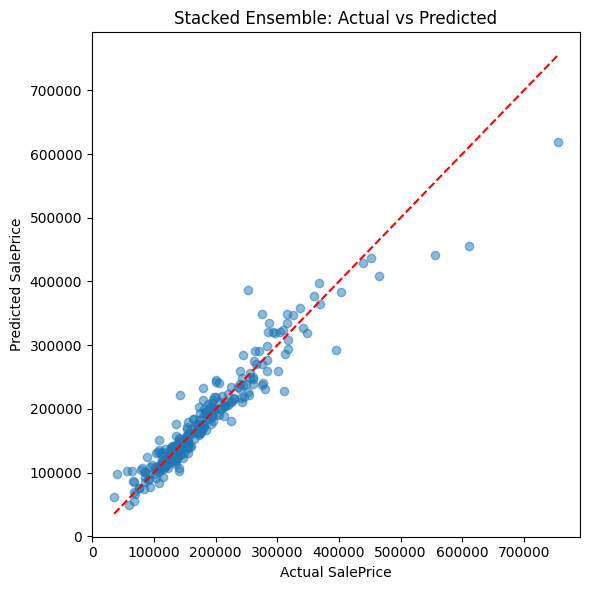

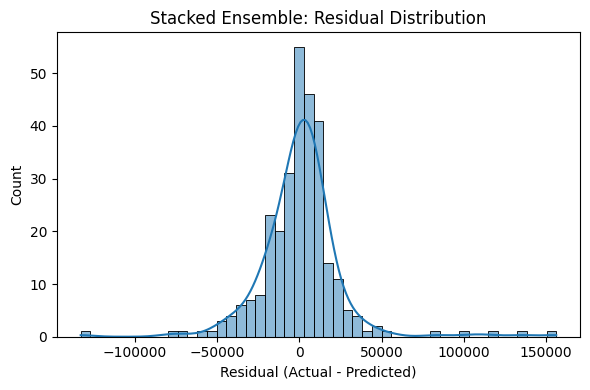

In [58]:
# ============================================
# STAGE 11 — Plots for best model (stacked)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we have predictions for stacked model
y_pred_best = y_pred_stack  # from previous cell

# 1) Actual vs Predicted scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Stacked Ensemble: Actual vs Predicted")
plt.tight_layout()
plt.show()

# 2) Residual histogram
residuals = y_test - y_pred_best

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Stacked Ensemble: Residual Distribution")
plt.tight_layout()
plt.show()
